# Example: Computing the Covariance Matrix for Logarithmic Returns
The covariance between the logarithmic return $r_{\star}$ on assets $i$ and $j$, denoted as $\text{cov}\left(r_{i},r_{j}\right)$, quantifies the relationship
between assets $i$ and $j$ in the portfolio $\mathcal{P}$:

$$
\begin{equation*}
    \Sigma_{ij} = \text{cov}\left(r_{i},r_{j}\right) = \sigma_{i}\sigma_{j}\rho_{ij}\qquad\text{for}\quad{i,j \in \mathcal{P}}
\end{equation*}
$$

where $\sigma_{\star}$ denote the standard deviation of the return of asset $\star$, and $\rho_{ij}$ 
denotes the correlation between assets $i$ and $j$ in the portfolio $\mathcal{P}$. The correlation is given by:

$$
\begin{equation*}
\rho_{ij} = \frac{\mathbb{E}(R_{i}-\mu_{i})\cdot\mathbb{E}(R_{j} - \mu_{j})}{\sigma_{i}\cdot\sigma_{j}}\qquad\text{for}\quad{i,j \in \mathcal{P}}
\end{equation*}
$$

The diagonal elements of the covariance matrix $\Sigma$ are the variances, 
while the off-diagonal measure the relationship between the assets in the portfolio $\mathcal{P}$.

## Learning objective
This example aims to familiarize students with estimating the return $R$ and covariance matrices $\Sigma$ from data and looking at the relationship between firms in our return dataset by sampling a multivariate normal distribution.

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`


### Constants

In [29]:
number_of_trading_days = 1256;
Δt = (1.0/252);
number_of_samples = 10000;

## Prerequisite: Load historical equity dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) for the past five-trading years (a maximum of `1256` data points per firm). We will exclude frims that do not have the maximum number of trading days from the `dataset`. 

We load the price `dataset` by calling the `MyPortfolioDataSet()` function. This returns the `dataset` variable, which is type `Dict{Int64,DataFrame}`

In [3]:
dataset = MyPortfolioDataSet() |> x-> x["dataset"];

The all keys array holds the list of firm indexes in the dataset that have complete data, i.e., all `1256` data values: 

In [4]:
list_of_all_firms = keys(dataset) |> collect |> sort;

While it is sometimes convenient to work with the data using the `firm_index`, often we want to specify the [ticker symbol](https://en.wikipedia.org/wiki/Ticker_symbol#:~:text=A%20ticker%20symbol%20or%20stock,on%20a%20particular%20stock%20market.) instead. To facilitate this, let's load a mapping between the `firm_index` and the ticker symbols using the `MyFirmMappingDataSet()` function:

In [5]:
firm_mapping = MyFirmMappingDataSet()

505×3 DataFrame
 Row │ Symbol   Name                    Sector                 
     │ String7  String                  String31               
─────┼─────────────────────────────────────────────────────────
   1 │ MMM      3M                      Industrials
   2 │ AOS      A. O. Smith             Industrials
   3 │ ABT      Abbott Laboratories     Health Care
   4 │ ABBV     AbbVie                  Health Care
   5 │ ABMD     Abiomed                 Health Care
   6 │ ACN      Accenture               Information Technology
   7 │ ATVI     Activision Blizzard     Communication Services
   8 │ ADM      ADM                     Consumer Staples
   9 │ ADBE     Adobe                   Information Technology
  10 │ AAP      Advance Auto Parts      Consumer Discretionary
  11 │ AMD      Advanced Micro Devices  Information Technology
  ⋮  │    ⋮               ⋮                       ⋮
 496 │ WLTW     Willis Towers Watson    Financials
 497 │ WYNN     Wynn Resorts            Consumer Discretionary
 498 │ XEL      Xcel Energy             Utilities
 499 │ XLNX     Xilinx                  Information Technology
 500 │ XYL      Xylem                   Industrials
 501 │ YUM      Yum! Brands             Consumer Discretionary
 502 │ ZBRA     Zebra Technologies      Information Technology
 503 │ ZBH      Zimmer Biomet           Health Care
 504 │ ZION     Zions Bancorp           Financials
 505 │ ZTS      Zoetis                  Health Care
                                               484 rows omitted

In [57]:
ticker_lookup_dictionary = Dict{String,Int64}();
number_of_map_elements = nrow(firm_mapping);
for i ∈ 1:number_of_map_elements
    ticker = firm_mapping[i,:Symbol];
    ticker_lookup_dictionary[ticker] = i;
end

## Compute the return and covariance matrix
Compute the expected log return by passing the `dataset` and a list of firms we are interested in (held in the $N\times{1}$ `list_of_all_firms` array) to the `log_growth_matrix(...)` method. The result is stored in the `return_matrix` variable, a $T-1\times{N}$ array of log return values.  Each row of `return_matrix` corresponds to a time-value, while each column corresponds to a firm: 

In [7]:
return_matrix = Δt*log_growth_matrix(dataset, list_of_all_firms)

1255×458 Matrix{Float64}:
  0.0158069     0.00586994    0.00296121   …   0.00713818    0.00815285
  0.0039873     0.0093903    -0.00173084      -0.00282514    0.0118091
  0.00155613    0.00747963   -0.00169811      -0.00141261    0.00979846
  0.0053433     0.00243087    0.000795871      0.0204302     0.0135465
  0.000134337   0.000864149  -0.00181885       0.0133607    -0.0193259
  0.000894703   0.0136076     0.000185609  …   0.00889023    0.00984934
  0.0134427     0.0133497     0.00307881       0.009512      0.0125042
  0.00185863    0.00438616   -0.00633965      -0.00616996    0.00439287
  0.0109241     0.00132812    0.00683518      -0.000404901   0.0112949
 -0.00702045    0.00449336   -6.27764e-5      -0.00200621   -0.004329
  0.00540192    0.0126991     0.00572525   …   0.00908432    0.00393979
 -0.00294251    0.00222886   -0.000558562      0.00750556    0.00588982
 -0.00211651   -0.00133253    0.000437088      0.00558505    0.00726033
  ⋮                                        ⋱ 

Next, we estimate the annualized `covariance_matrix` from the `return_matrix` using the `cov(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the `covariance_matrix` in the `Σ` variable:

In [8]:
Σ = 252*cov(return_matrix);

## Visualize the relationship between firms
Pick any two firms from the `dataset` by finding their `ticker` symbol in the `ticker_lookup_dictionary`. 
Note: the `Σ` matrix is in the same order as the `list_of_all_firms` array; thus, to find the index of a `ticker`, we need to search the `list_of_all_firms` array for the `firm_index`:

In [92]:
i = findfirst(x->x == ticker_lookup_dictionary["AIG"], list_of_all_firms); 
j = findfirst(x->x == ticker_lookup_dictionary["WFC"], list_of_all_firms);

### Construct the mean return for a full year for firms `i` and `j`

In [93]:
μ̂ = 252*[mean(return_matrix[:,i]), mean(return_matrix[:,j])]

2-element Vector{Float64}:
  0.010383937883105045
 -0.08050302761147546

### Construct the covariance matrix for firms `i` and `j`

In [94]:
Σ̂ = [
    Σ[i,i] Σ[i,j] ;
    Σ[j,i] Σ[j,j] ;
];

For visualization purposes (and ease of use), let's assume the returns were drawn from a [Multivariate Normal Distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) with mean $\hat{\mu}$ and covariance $\hat{\Sigma}$. We use the `MvNormal(...)` function from the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl.git) package:

In [95]:
d = MvNormal(μ̂,Σ̂);

#### Visualize

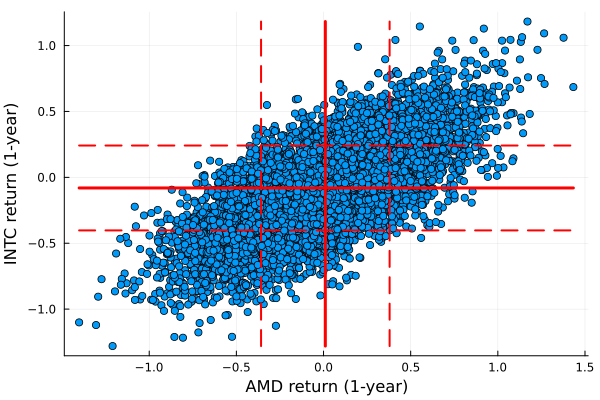

In [96]:
X = rand(d, number_of_samples);
MU_VERT_LINE_1 = zeros(number_of_samples,2);
MU_VERT_LINE_2 = zeros(number_of_samples,2);
MU_VERT_LINE_1[:,1] .= μ̂[1]*ones(number_of_samples);
MU_VERT_LINE_1[:,2] .= range(minimum(X[2,:]),stop=maximum(X[2,:]),length = number_of_samples);
MU_VERT_LINE_2[:,2] .= μ̂[2]*ones(number_of_samples);
MU_VERT_LINE_2[:,1] .= range(minimum(X[1,:]),stop=maximum(X[1,:]),length = number_of_samples);
scatter(X[1,:], X[2,:], xlabel="AMD return (1-year)", ylabel="INTC return (1-year)", label="")

# plot the mean lines -
plot!(MU_VERT_LINE_1[:,1], MU_VERT_LINE_1[:,2],c=:red,lw=3, label="")
plot!(MU_VERT_LINE_2[:,1], MU_VERT_LINE_2[:,2],c=:red,lw=3, label="")

# plot the std lines -
plot!(MU_VERT_LINE_1[:,1].+ sqrt(Σ[i,i]), MU_VERT_LINE_1[:,2],c=:red,lw=2, ls=:dash, label="")
plot!(MU_VERT_LINE_1[:,1].- sqrt(Σ[i,i]), MU_VERT_LINE_1[:,2],c=:red,lw=2, ls=:dash, label="")
plot!(MU_VERT_LINE_2[:,1], MU_VERT_LINE_2[:,2] .+ sqrt(Σ[j,j]),c=:red,lw=2, ls=:dash, label="")
plot!(MU_VERT_LINE_2[:,1], MU_VERT_LINE_2[:,2] .- sqrt(Σ[j,j]),c=:red,lw=2, ls=:dash, label="")

### Compute the correlation
Finally, we estimate the correlation $\rho$ between firm `i` and `j` using the `cor(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the correlation in the `ρ` variable:

In [97]:
ρ = cor(X[1,:],X[2,:])
println("The correlation between firm i = $(i) and j = $(j) equals: ρ = $(ρ)")

The correlation between firm i = 31 and j = 443 equals: ρ = 0.7007914777275311
